In [1]:
# Load required tudatpy modules
import numpy as np
from matplotlib import pyplot as plt
from tudatpy.interface import spice
from tudatpy.astro import time_conversion, element_conversion
from tudatpy.math import interpolators
from tudatpy import numerical_simulation
from tudatpy.numerical_simulation import environment_setup, environment, propagation_setup, estimation, estimation_setup
from tudatpy.numerical_simulation.estimation_setup import observation
from tudatpy.numerical_simulation.environment import Tle
from datetime import datetime, timedelta
import matplotlib.dates as mdatesx  
from itertools import zip_longest
from tudatpy.util import result2array
import math

from my_functions import sat_prop, tle_epoch_to_datetime, compute_tle_checksum,sat_prop_two_body, state_eci_to_radec, sat_prop_with_stm

spice.load_standard_kernels()

ImportError: cannot import name 'state_eci_to_radec' from 'my_functions' (c:\Users\kesh3\Delft University of Technology\Master Thesis Sensor Management in cislunar space-PRJ - General\Code\my_functions.py)

In [ ]:
def measurement_model(x_eci,gs_eci):
    # Computing observables
    pos_topo = x_eci[0:3] - gs_eci
    range = np.sqrt(pos_topo[0]**2 + pos_topo[1]**2 + pos_topo[2]**2)
    ra = math.atan2(pos_topo[1],pos_topo[0])
    dec = math.asin(pos_topo[2]/range)

    h = [ra,dec]

    H11 = pos_topo[0]/range
    H12 = pos_topo[1]/range
    H13 = pos_topo[2]/range
    H21 = -pos_topo[1]/(pos_topo[0]**2 * (1 + (pos_topo[1]/pos_topo[0])**2))
    H22 = 1/(pos_topo[0] * (1 + (pos_topo[1]/pos_topo[0])**2))
    H31 = -pos_topo[2] * pos_topo[0]/(range**3 * np.sqrt(1-pos_topo[2]**2/range**2))
    H32 = -pos_topo[2] * pos_topo[1]/(range**3 * np.sqrt(1-pos_topo[2]**2/range**2))
    H33 = (1/range - pos_topo[2]**2/range**3) / np.sqrt(1-(pos_topo[2]/range)**2)

    H_w_range = np.array([[H11, H12, H13,0,0,0],[H21, H22,0,0,0,0],[H31, H32, H33,0,0,0]])

    H = H_w_range[1:,:]

    return h,H


In [ ]:
def ekf_update(mu, cov, z_meas,z_pred, H_matrix, R):

    # Innovation (residual) between actual and predicted measurement
    y = z_meas - z_pred

    # Innovation covariance
    S = H_matrix @ cov @ H_matrix.T + R

    # Kalman gain
    K = cov @ H_matrix.T @ np.linalg.inv(S)

    # Updated state estimate (posterior mean)
    mu_post = mu + K @ y

    # Updated covariance
    I = np.eye(len(mu))
    cov_post = (I - K @ H_matrix) @ cov

    return mu_post, cov_post

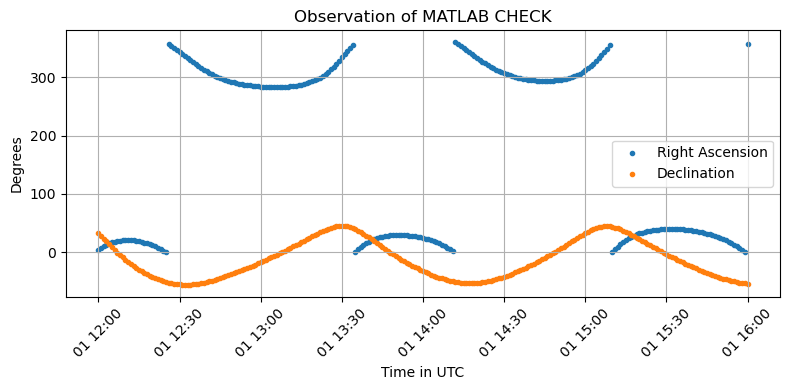

In [ ]:
# targets = ["GSAT0101 (GALILEO-PFM)","STARLINK-1008","ISS (ZARYA)"]
targets = ["MATLAB CHECK"]

station_name ='REY30' 
# geodetic_position = {'REY30': [3058.789875087734,20.709152020592995, -156.2600015424928]}    # alt, lat, lon (m,deg,deg)
geodetic_position = {'REY30': [3058.789875087734,20.709152020592995, -156.2600015424928]}

# Select the global frame and orientation 
global_frame_origin = 'Earth'
global_frame_orientation = 'J2000'

# Initializing TLE from celestrack
tle_ISS_line1 = "1 25544U 98067A   25147.20450743  .00010885  00000+0  20003-3 0  9993"
tle_ISS_line2 = "2 25544  51.6384  51.0343 0002206 149.5344 343.0812 15.49769564511908"
 
tle_galileo_line1 = "1 37846U 11060A   25144.52916540 -.00000075  00000+0  00000+0 0  9995"
tle_galileo_line2 = "2 37846  57.0978 352.2961 0003612  39.4719 320.5962  1.70475644 84499"
         
tle_starlink_line1 = "1 44714U 19074B   25145.95841286  .00000108  00000+0  26155-4 0  9992"
tle_starlink_line2 = "2 44714  53.0564  38.2925 0002036  81.0993 279.0226 15.06391243305386"

tle_line1 = ["1 37846U 11060A   25144.52916540 -.00000075  00000+0  00000+0 0  9995","1 44714U 19074B   25145.95841286  .00000108  00000+0  26155-4 0  9992","1 25544U 98067A   25147.20450743  .00010885  00000+0  20003-3 0  9993"]
tle_line2 = ["2 37846  57.0978 352.2961 0003612  39.4719 320.5962  1.70475644 84499","2 44714  53.0564  38.2925 0002036  81.0993 279.0226 15.06391243305386","2 25544  51.6384  51.0343 0002206 149.5344 343.0812 15.49769564511908"]

tles = dict()

# Converting TLE time from UTC to TT
for idx in range (0,len(targets)):
    temp_time_utc = tle_line1[idx][18:32]
    temp_time_utc_fl = float(temp_time_utc)
    temp_time_tt = temp_time_utc_fl - 0.00081019
    temp_time_tt_fl = f"{temp_time_tt:.8f}".rjust(14)  # pad with spaces if needed
    tle_line1[idx] = tle_line1[idx][:18] + temp_time_tt_fl + tle_line1[idx][32:68]
    checksum = compute_tle_checksum(tle_line1[idx])
    tle_line1[idx] = tle_line1[idx] + checksum
    
    tles[targets[idx]] = Tle(tle_line1[idx],tle_line2[idx])


# Defining time window of simulation from TLE epoch to Tle epoch + 1 day
tle_epoch = tle_ISS_line1[18:32]
start_epoch = tle_epoch_to_datetime(tle_epoch)
end_epoch = start_epoch + timedelta(days=1)

time_format = '%Y-%m-%d %H:%M:%S'

# start_epoch_string = start_epoch.strftime(time_format)
# end_epoch_string = end_epoch.strftime(time_format)

# Time window corresponding to Heavens Above data
start_epoch_string = "2000-01-01 12:00:00"
end_epoch_string = "2000-01-01 16:00:00"

time_step_string = '1m'
time_step_seconds = 60

# Get start and end time in UTS, Julian Day and seconds since J2000
jd_start_epoch = time_conversion.calendar_date_to_julian_day(datetime.strptime(start_epoch_string, time_format))
jd_end_epoch = time_conversion.calendar_date_to_julian_day(datetime.strptime(end_epoch_string, time_format))
time_buffer = 0

utc_simulation_start_epoch = time_conversion.julian_day_to_calendar_date(jd_start_epoch - time_buffer)
utc_simulation_end_epoch = time_conversion.julian_day_to_calendar_date(jd_end_epoch + time_buffer)

# sim_seconds_start_epoch = time_conversion.julian_day_to_seconds_since_epoch(jd_start_epoch - time_buffer)
# sim_seconds_end_epoch = time_conversion.julian_day_to_seconds_since_epoch(jd_end_epoch + time_buffer)
sim_seconds_start_epoch = 0.0
sim_seconds_end_epoch = 14460.0

bodies_to_create = ["Earth","Sun","Moon"]
central_bodies = ["Earth"]

# Creating Earth settings
body_settings = environment_setup.get_default_body_settings_time_limited(bodies_to_create, sim_seconds_start_epoch, sim_seconds_end_epoch, global_frame_origin, global_frame_orientation)
for target in targets:
    body_settings.add_empty_settings(target)
    body_settings.add_empty_settings(target+"_est")
   
# Add Earth Shape settings
eq_rad = 6378*1e3 # in meters
flat = 1/298
body_settings.get('Earth').shape_settings = environment_setup.shape.oblate_spherical(equatorial_radius = eq_rad,flattening = flat,)

# Add Earth Rotation model
body_settings.get('Earth').rotation_model_settings = environment_setup.rotation_model.gcrs_to_itrs(
    environment_setup.rotation_model.iau_2006, global_frame_orientation,
    interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                            sim_seconds_start_epoch, sim_seconds_end_epoch, 60),
    interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                            sim_seconds_start_epoch, sim_seconds_end_epoch, 60),
    interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                            sim_seconds_start_epoch, sim_seconds_end_epoch, 60))

# body_settings.get('Earth').rotation_model_settings = environment_setup.rotation_model.gcrs_to_itrs(
#     base_frame="IAU_Earth",
#     target_frame="J2000"
# )

# # CREATE ACCELERATION SETTINGS
# # Aerodynamic drag
# ref_area = np.pi * 0.5**2
# drag_coef = 2.0
# aero_coef_settings = environment_setup.aerodynamic_coefficients.constant(ref_area,[drag_coef,0.0,0.0])

# # Solar radiation pressure
# rad_coef = 1.2
# occulting_bodies_dict = dict()
# occulting_bodies_dict["Sun"] = ["Earth"]
# vehicle_target_settings = environment_setup.radiation_pressure.cannonball_radiation_target(
#     ref_area, rad_coef, occulting_bodies_dict)

# body_settings.get(target).aerodynamic_coefficient_settings = aero_coef_settings
# body_settings.get(target).radiation_pressure_target_settings = vehicle_target_settings

# bodies = environment_setup.create_system_of_bodies(body_settings)
# bodies.get(target).mass = 10

# accelerations_settings_target = dict(
#     Sun=[
#         propagation_setup.acceleration.radiation_pressure(),
#         propagation_setup.acceleration.point_mass_gravity()
#     ],
#     Earth=[
#         propagation_setup.acceleration.spherical_harmonic_gravity(8, 8),
#         propagation_setup.acceleration.aerodynamic()
#     ],
#     Moon=[
#         propagation_setup.acceleration.point_mass_gravity()
#     ],
# )

# # Create global accelerations settings dictionary.
# acceleration_settings = {target: accelerations_settings_target}

# # Create numerical integrator settings
# fixed_step_size = 60.0
# integrator_settings = propagation_setup.integrator.runge_kutta_fixed_step(
#     fixed_step_size, coefficient_set=propagation_setup.integrator.CoefficientSets.rk_4
# )

initial_state =    1.0e+06 * np.array([0.7577,5.222607,4.8515,0.00221321,0.00467834,-0.0053713])

# Get true propogated satellite coordinates from tudat propogator
true_states = dict()
for target in targets:
    # true_states[target] = sat_prop(sim_seconds_start_epoch, sim_seconds_end_epoch-60, target, tles[target])
    true_states[target] = sat_prop(sim_seconds_start_epoch, sim_seconds_end_epoch-60, target, target_TLE=None,target_initial_state=initial_state)
    # true_states[target] = sat_prop_two_body(sim_seconds_start_epoch, sim_seconds_end_epoch-60, target,target_initial_state=initial_state)
    

# 1) Build a dict-of-dicts of ephemeris samples:
targets_states_dicts = {
    target: {
        float(row[0]): row[1:].reshape((6,1))
        for row in state
    }
    for target, state in true_states.items()
}

# 2) Assign each one into your body_settings:
for target, state in targets_states_dicts.items():
    body_settings.get(target).ephemeris_settings = environment_setup.ephemeris.tabulated(state,global_frame_origin,global_frame_orientation)

# Set up ground station settings
gs_alt_m = geodetic_position[station_name][0]
gs_lat_deg = geodetic_position[station_name][1]
gs_lon_deg = geodetic_position[station_name][2]

gs_ecef = [-5466071, -2403990,  2242473]
gs_eci = {}

gs_settings = []
gs_settings.append(environment_setup.ground_station.basic_station(
    station_name,[gs_alt_m,np.deg2rad(gs_lat_deg),np.deg2rad(gs_lon_deg)],element_conversion.geodetic_position_type))

body_settings.get('Earth').ground_station_settings = gs_settings

bodies = environment_setup.create_system_of_bodies(body_settings)

earth_rotation_model = bodies.get('Earth').rotation_model

true_radec = {}

for target,state in targets_states_dicts.items():
    true_radec[target] = {}
    
    for t in targets_states_dicts[target].keys():

        # Use RotationalEphemeris to get rotation matrix
        R_fixed_to_inertial = earth_rotation_model.body_fixed_to_inertial_rotation(t)

        # Apply rotation to get ECI position
        gs_eci[t] = R_fixed_to_inertial @ gs_ecef
        # print(gs_eci[t])
        # print(t)
    
        ra,dec = state_eci_to_radec(state[t].reshape(6,),gs_eci[t])
        true_radec[target][t] = [ra,dec]

    times = []
    times_utc = []
    for t in sorted(true_radec[target].keys()):
        times.append(t)
        time_change_jd = time_conversion.seconds_since_epoch_to_julian_day(t)
        time_change_utc = time_conversion.julian_day_to_calendar_date(time_change_jd)
        times_utc.append(time_change_utc)


    ras = [np.rad2deg(true_radec[target][t][0]) % 360 for t in times]  # RA in degrees, wrapped
    decs = [np.rad2deg(true_radec[target][t][1]) for t in times]       # Dec in degrees

    # x_vals = [state[t][0] for t in times]
    # y_vals = [state[t][1] for t in times]
    # z_vals = [state[t][2] for t in times]

    # fig, axs = plt.subplots(3, 1, figsize=(6, 6))
    # axs[0].plot(times_utc, x_vals)
    # axs[0].set_title('X axis')
    # axs[1].plot(times_utc,  y_vals)
    # axs[1].set_title('Y axis')
    # axs[2].plot(times_utc,  z_vals)
    # axs[2].set_title('Z axis')
    # plt.tight_layout()
    # plt.show()

    plt.figure(figsize=(8, 4))
    plt.scatter(times_utc,ras,marker='.',label='Right Ascension')
    plt.scatter(times_utc,decs,marker='.',label='Declination')
    plt.title('Observation of '+target)
    plt.xlabel('Time in UTC')
    plt.ylabel('Degrees')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


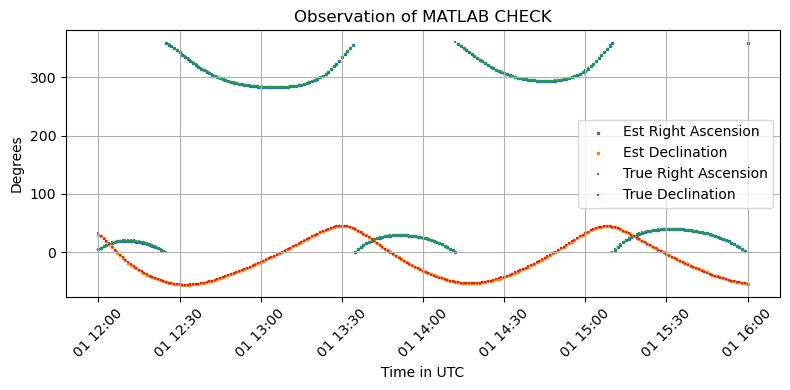

In [ ]:

q_pos = 1e-12    # m^2
q_vel = 0.0   # (m/s)^2
# Q = np.block([
#     [q_pos * np.eye(3), np.zeros((3, 3))],
#     [np.zeros((3, 3)), q_vel * np.eye(3)]
# ])
Q = np.eye(3) * q_pos

# measurement noise covariance R  (radians^2)
R = np.diag([1e-10 * 0.235043863818291, 1e-10 * 0.235043863818291])

est_state = {target: dict() for target in targets}
est_cov   = {target: dict() for target in targets}
est_ra    = {target: dict() for target in targets}  # will store in radians
est_dec    = {target: dict() for target in targets}
true_ra_deg    = {target: dict() for target in targets}
true_dec_deg    = {target: dict() for target in targets}

es_times_filtered = []

for target in targets:
    # get initial mean from TLE ephemeris at start time
    # tle_ephem = environment.TleEphemeris("Earth","J2000", tles[target], False)
    # mu0 = tle_ephem.cartesian_state(sim_seconds_start_epoch).flatten()
    mu0 = initial_state
    # 1 km σ in pos, 1 m/s σ in vel
    cov0 = np.diag([1e2,1e2,1e2,1e-1,1e-1,1e-1])
    est_state[target][0] = mu0
    est_cov[target][0] = cov0 

station_id = ('Earth', station_name)


for target in targets:

    for idx,t in enumerate(times):
        # # EKF prediction with 2 body STM Jacobian
        # prop_temp = sat_prop(t,t+time_step_seconds,target,target_TLE= None, target_initial_state=est_state[target][idx])
        # state_pred = prop_temp[-1][1:]
        # r_prev = est_state[target][idx][:3]  # position vector at time k-1
        # r_norm = np.linalg.norm(r_prev)
        # if (not np.isfinite(r_norm)) or (r_norm < 1e-2):
        #     print(f"Warning: r_norm = {r_norm:.3e} < 1e-3 at idx {idx}, t={t}")
        #     A_r = np.zeros((3,3))
        # elif(r_norm > 1e15 ):
        #     print(f"Warning: r_norm = {r_norm:.3e} > 1e15 at idx {idx}, t={t}")
        #     A_r = np.zeros((3,3))
        # else:
        #     dt = 60
        #     I3  = np.eye(3)
        #     rrT = np.outer(r_prev, r_prev)
        #     mu  = 398600.4418e9
        #     A_r = -mu * (I3 / r_norm**3 - 3 * rrT / r_norm**5)
        # F_k = np.block([[I3, dt * I3],
        #             [A_r * dt, I3   ]])
        # cov_pred = F_k @ est_cov[target][idx] @ (F_k.T) + Q
        
        # EKF prediction with perturbed STM Jacobain using tudats variational_equations_solver
        temp_state,stm_k = sat_prop_with_stm(t,t+time_step_seconds,target,est_state[target][idx])
        state_pred = list(temp_state.values())[-1].flatten()
        Phi_k = list(stm_k.values())[-1]  # 6x6 matrix

        Gamma_k = np.zeros([6, 3])
        Gamma_k[0:3,:] = 0.5 * time_step_seconds^2 * np.eye(3)
        Gamma_k[3:,:] = time_step_seconds * np.eye(3)


        cov_pred = Phi_k @ est_cov[target][idx] @ Phi_k.T  + Gamma_k @ Q @ Gamma_k
       
       # Creating measured values vector
        temp_true_ra_rad = (true_radec[target][t][0])
        temp_true_dec_rad = (true_radec[target][t][1])
        
        z_meas = np.array([temp_true_ra_rad, temp_true_dec_rad]) + np.random.normal(0, R[0][0], size=2)

        # Predicted measurement and measurement matrix jacobian
        z_pred,H_matrix = measurement_model(state_pred,gs_eci[t])

        # EKF update to get posterior
        state_post, cov_post = ekf_update(state_pred, cov_pred, z_meas,z_pred, H_matrix, R)

        est_state[target][idx+1] = state_post
        est_cov[target][idx+1] = cov_post
        
        ra_post,dec_post = state_eci_to_radec(state_post,gs_eci[t])

        # Storing stuff
        est_ra[target][idx] = (np.rad2deg(ra_post) % 360)
        est_dec[target][idx] = (np.rad2deg(dec_post))
        true_ra_deg[target][idx] = np.rad2deg(temp_true_ra_rad) % 360
        true_dec_deg[target][idx] = np.rad2deg(temp_true_dec_rad)

    plt.figure(figsize=(8, 4))
    plt.scatter(times_utc,est_ra[target].values(),marker='x',s=3,label='Est Right Ascension')
    plt.scatter(times_utc,est_dec[target].values(),marker='x',s=3,label='Est Declination')
    plt.scatter(times_utc,true_ra_deg[target].values(),marker='+',s=3,label='True Right Ascension')
    plt.scatter(times_utc,true_dec_deg[target].values(),marker='+',s=3,label='True Declination')
    plt.title('Observation of '+target)
    plt.xlabel('Time in UTC')
    plt.ylabel('Degrees')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

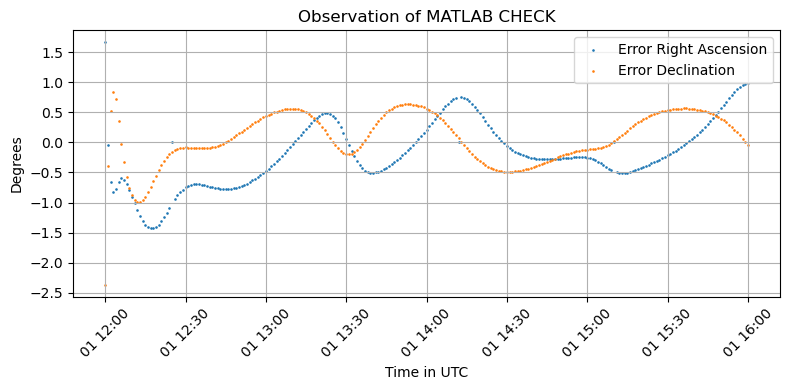

In [ ]:
ra_err = np.array(list(est_ra[target].values())) - np.array(list(true_ra_deg[target].values()))
ra_err[np.abs(ra_err) > 180] = 0
dec_err = np.array(list(est_dec[target].values())) - np.array(list(true_dec_deg[target].values()))

plt.figure(figsize=(8, 4))
plt.scatter(times_utc,ra_err,marker='.',s=3,label='Error Right Ascension')
plt.scatter(times_utc,dec_err,marker='.',s=3,label='Error Declination')
# plt.scatter(times_utc,true_ra_deg[target].values(),marker='+',s=2,label='True Right Ascension')
# plt.scatter(times_utc,true_dec_deg[target].values(),marker='+',s=2,label='True Declination')
plt.title('Observation of '+target)
plt.xlabel('Time in UTC')
plt.ylabel('Degrees')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
